This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

The filter is pretty fast. The wrapper is what takes the most time. The two most important paramenters are the number of variables you want to save from the filter (num_filter) and the number you want from the wrapper (num_wrapper). 

There's a parameter njobs that controls the # threads used in the wrapper. Set it to 1 for a single thread and it should work fine, but you might be able to succeed with njobs = -1, which lets the machine set the maximum # threads based on the CPU. With this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.

Recommendations: Try a few simple runs just to make sure all's working. Start with num_filter = 20, num_wrapper = 5, increase from there. I like num_filter as high as around 10 to 20% of the # candidate variables, but not much higher than a few hundred. You don't need num_wrapper large if you're doing forward selection. Most problems will saturate before 20. You can try a few different simple wrapper models like RF (5 trees, 10 layers), catboost (10 trees, 3 layers), LGBM (same). They're pretty fast. You can try forward and backward. I'd start with forward. In the end, select one of these as your favorite run and go with those variables. Don't mix variables across different runs.

I find forward selection runs much faster than backward.

Make sure your validation/out-of-time population and any other record exclusion is set correctly and as you want for your problem in cell 3.

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
# set some parameters
num_files = 1 # This is number of files you have for feature selection. Usually this will just be 1.

# This is the number of variables from the filter that you want the wrapper to consider.
# Make it as high as your machine and time can handle. 
# I recommend set num_filter to be at least about 10 to 20% of the original # variables. 
num_filter = 100

# I recommend set num_wrapper to be about 30, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper about twice this saturation number.
num_wrapper = 20

balance = 0 # a nonzero value will then be ratio of goods to bads.

# This is a cutpoint for measuring a detection rate. It's not that important to get it exact. 
# Set it around where you think the business cutoff is expected to be.
detect_rate = .03

index_name = 'record'  # set this string as whatever your record number field is called
y_name = 'fraud_label' # set this string to be whatever your binary label is called
good_label = 0  # you can make the goods or bads zero or 1. If you want high to be bad, then set bad=1, good=0.
bad_label = 1

# You need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# Frequently we want to ignore some early records (if not, set the ignore_records_below to 0)
# We may want to ignore some later records, for example an out-of-time data set.
ignore_records_above = 833507 # remove the last two months as the out-of-time data (OOT)
ignore_records_below = 38511 # remove the first 2 weeks of records since their variables aren't well formed

## Run a filter on all the files

In [5]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv' # if you only have one file for variables, set num_files=1 and put the name of the file here.
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
# you need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# frequently we want to ignore some early records (if not, set the )
    df = df[df.index <= ignore_records_above] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= ignore_records_below] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (1000000, 654)


<timed exec>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'fraud_label' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
vars.csv                                        variable  filter score
0                                   fraud_label      1.000000
613                 max_count_by_fulladdress_30      0.359914
593                     max_count_by_address_30      0.359215
592                      max_count_by_address_7      0.343335
612                  max_count_by_fulladdress_7      0.343052
11                            address_day_since      0.334140
46                        fulladdress_day_since      0.333269
17                             address_count_30      0.332648
52                         fulladdress_count_30      0.331969
611                  max_count_by_fulladdress_3      0.329538
591                      max_count_by_address_3      0.329445
16                             address_count_14      0.322436
51                         fulladdress_count_14      0.321953
590                      max_count_by_address_1      0.315332
610                  max_count_by_ful

In [6]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [7]:
filter_score.head(30)

,variable,filter score
0,fraud_label,1.000000
1,max_count_by_fulladdress_30,0.359914
2,max_count_by_address_30,0.359215
3,max_count_by_address_7,0.343335
4,max_count_by_fulladdress_7,0.343052
5,address_day_since,0.334140
6,fulladdress_day_since,0.333269
7,address_count_30,0.332648
8,fulladdress_count_30,0.331969
9,max_count_by_fulladdress_3,0.329538


In [8]:
filter_score.tail(10)

,variable,filter score
644,name_homephone_unique_count_for_dob_3,0.000039
645,name_homephone_unique_count_for_dob_0,0.000038
646,name_fulladdress_unique_count_for_dob_0,0.000037
647,address_unique_count_for_zip5_0,0.000033
648,name_homephone_unique_count_for_address_0,0.000009
649,name_homephone_unique_count_for_zip5_0,0.000005
650,name_fulladdress_unique_count_for_zip5_30,0.000001
651,ssn_fulladdress,0.000000
652,address_unique_count_for_fulladdress_dob_0,0.000000
653,dummy,0.000000


In [9]:
filter_score.shape

(654, 2)

In [10]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_name_60', 'fulladdress_unique_count_for_ssn_60', 'address_unique_count_for_ssn_60', 'fulladdress_unique_count_for_name_60', 'address_unique_count_for_name_homephone_30', 'fulladdress_unique_count_for_name_homephone_30', 'fulladdress_unique_count_for_dob_60', 'address_unique_count_for_dob_60', 'fulladdress_unique_count_for_ssn_30', 'address_count_0_by_14', 'fulladdress_count_0_by_14', 'address_unique_coun

In [11]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,max_count_by_fulladdress_30,max_count_by_address_30,max_count_by_address_7,max_count_by_fulladdress_7,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,max_count_by_fulladdress_3,max_count_by_address_3,...,max_count_by_zip5_3,zip5_unique_count_for_name_homephone_3,zip5_unique_count_for_dob_3,zip5_unique_count_for_ssn_3,zip5_unique_count_for_name_3,zip5_count_1,zip5_unique_count_for_name_fulladdress_3,max_count_by_fulladdress_homephone_3,fulladdress_homephone_count_14,address_count_1_by_30
record,,,,,,,,,,,,,,,,,,,,,
38511,14,14,10,10,0.0,0.0,12,12,6,6,...,8,4,4,4,4,2,4,1,1,5.0
38512,1,1,1,1,365.0,365.0,1,1,1,1,...,9,1,1,1,1,1,1,1,1,30.0
38513,1,1,1,1,365.0,365.0,1,1,1,1,...,5,1,1,1,1,1,1,1,1,30.0
38514,1,1,1,1,365.0,365.0,1,1,1,1,...,6,2,2,2,2,2,2,1,1,30.0
38515,1,1,1,1,365.0,365.0,1,1,1,1,...,6,1,1,1,1,1,1,1,1,30.0


In [12]:
df_keep.shape

(794997, 100)

In [13]:
Y.head()

,fraud_label
record,
38511,1
38512,0
38513,0
38514,0
38515,0


In [14]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [15]:
# Y = np.array(Y)
X = df_keep
print(Y)

[1 0 0 ... 0 0 0]


In [16]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:01:48.008731


In [17]:
print(X.shape,Y.shape)

(794997, 100) (794997,)


In [18]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [19]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [20]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = 1

In [21]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
#clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
#sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

CPU times: user 53min 14s, sys: 1min 40s, total: 54min 54s
Wall time: 55min 11s


SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5),
                          k_features=(20, 20),
                          scoring=<function fdr at 0x156a62940>)

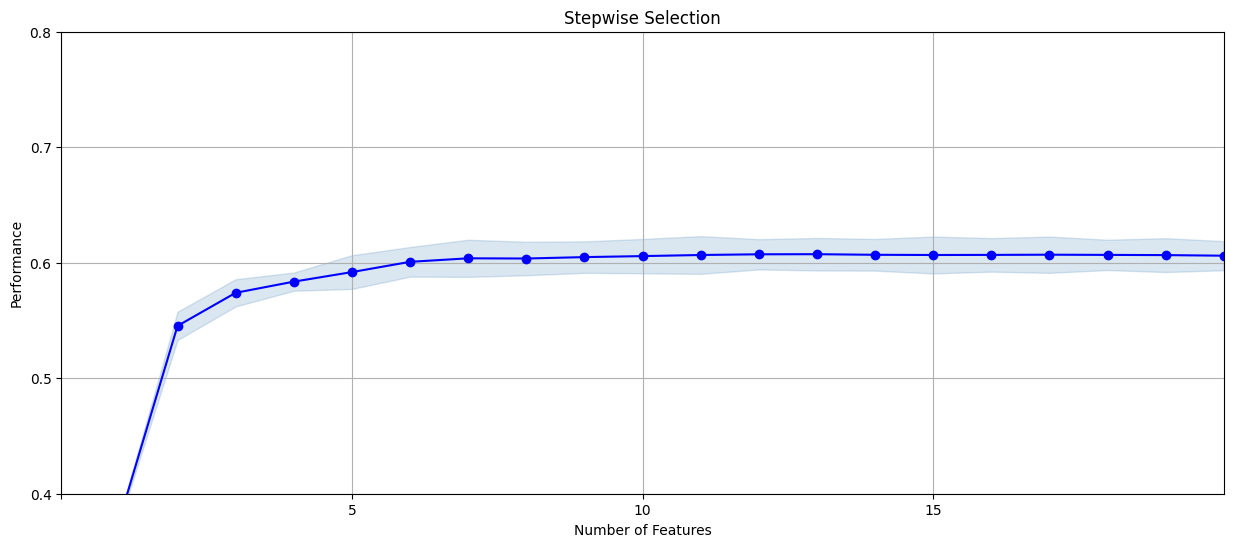

In [22]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [23]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [24]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [25]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.37970055710306405, 0.3748911718613965]",0.377296,"(max_count_by_address_30,)",0.010347,0.002405,0.002405,1.0,max_count_by_address_30
2,"(1, 84)","[0.5330779944289693, 0.5575483196935399]",0.545313,"(max_count_by_address_30, max_count_by_ssn_7)",0.052644,0.012235,0.012235,2.0,max_count_by_ssn_7
3,"(1, 79, 84)","[0.5621518105849582, 0.5857565732195716]",0.573954,"(max_count_by_address_30, max_count_by_homepho...",0.050782,0.011802,0.011802,3.0,max_count_by_homephone_7
4,"(1, 7, 79, 84)","[0.5757311977715878, 0.5915026989378374]",0.583617,"(max_count_by_address_30, fulladdress_count_30...",0.03393,0.007886,0.007886,4.0,fulladdress_count_30
5,"(1, 7, 79, 84, 95)","[0.5772980501392758, 0.6064774508096814]",0.591888,"(max_count_by_address_30, fulladdress_count_30...",0.062774,0.01459,0.01459,5.0,zip5_count_1
6,"(0, 1, 7, 79, 84, 95)","[0.5879178272980501, 0.613616576702072]",0.600767,"(max_count_by_fulladdress_30, max_count_by_add...",0.055286,0.012849,0.012849,6.0,max_count_by_fulladdress_30
7,"(0, 1, 7, 77, 79, 84, 95)","[0.5877437325905293, 0.6198850774856347]",0.603814,"(max_count_by_fulladdress_30, max_count_by_add...",0.069147,0.016071,0.016071,7.0,max_count_by_fulladdress_homephone_7
8,"(0, 1, 7, 47, 77, 79, 84, 95)","[0.5891364902506964, 0.6181438272679785]",0.60364,"(max_count_by_fulladdress_30, max_count_by_add...",0.062404,0.014504,0.014504,8.0,fulladdress_unique_count_for_name_homephone_7
9,"(0, 1, 7, 12, 47, 77, 79, 84, 95)","[0.591225626740947, 0.6184920773115097]",0.604859,"(max_count_by_fulladdress_30, max_count_by_add...",0.058659,0.013633,0.013633,9.0,max_count_by_address_1
10,"(0, 1, 7, 12, 47, 64, 77, 79, 84, 95)","[0.5908774373259053, 0.6205815775726972]",0.60573,"(max_count_by_fulladdress_30, max_count_by_add...",0.063903,0.014852,0.014852,10.0,max_count_by_fulladdress_homephone_30


In [26]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [27]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                           max_count_by_address_30
2                                max_count_by_ssn_7
3                          max_count_by_homephone_7
4                              fulladdress_count_30
5                                      zip5_count_1
6                       max_count_by_fulladdress_30
7              max_count_by_fulladdress_homephone_7
8     fulladdress_unique_count_for_name_homephone_7
9                            max_count_by_address_1
10            max_count_by_fulladdress_homephone_30
11                  address_unique_count_for_ssn_14
12              fulladdress_unique_count_for_name_1
13                 address_unique_count_for_name_30
14             max_count_by_fulladdress_homephone_3
15                             address_count_0_by_3
16                             address_count_0_by_7
17             fulladdress_unique_count_for_name_14
18                                 address_count_30
19              fulladdress_unique_count_for_ssn_60
20          

In [28]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
name_homephone_unique_count_for_zip5_0,0.000005
name_fulladdress_unique_count_for_zip5_30,0.000001
ssn_fulladdress,0.000000


In [29]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
max_count_by_ssn_7
max_count_by_homephone_7
fulladdress_count_30
zip5_count_1


In [30]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [31]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,max_count_by_address_30,0.359215
1,2,max_count_by_ssn_7,0.227428
2,3,max_count_by_homephone_7,0.232235
3,4,fulladdress_count_30,0.331969
4,5,zip5_count_1,0.221239
5,6,max_count_by_fulladdress_30,0.359914
6,7,max_count_by_fulladdress_homephone_7,0.234463
7,8,fulladdress_unique_count_for_name_homephone_7,0.273366
8,9,max_count_by_address_1,0.315332
9,10,max_count_by_fulladdress_homephone_30,0.249724


In [32]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_7',
 'max_count_by_homephone_7',
 'fulladdress_count_30',
 'zip5_count_1',
 'max_count_by_fulladdress_30',
 'max_count_by_fulladdress_homephone_7',
 'fulladdress_unique_count_for_name_homephone_7',
 'max_count_by_address_1',
 'max_count_by_fulladdress_homephone_30',
 'address_unique_count_for_ssn_14',
 'fulladdress_unique_count_for_name_1',
 'address_unique_count_for_name_30',
 'max_count_by_fulladdress_homephone_3',
 'address_count_0_by_3',
 'address_count_0_by_7',
 'fulladdress_unique_count_for_name_14',
 'address_count_30',
 'fulladdress_unique_count_for_ssn_60',
 'fulladdress_unique_count_for_ssn_30',
 'record',
 'fraud_label']

In [33]:
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
name_homephone_unique_count_for_zip5_0,0.000005
name_fulladdress_unique_count_for_zip5_30,0.000001
ssn_fulladdress,0.000000


In [34]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 17.2 s, sys: 6.55 s, total: 23.8 s
Wall time: 27 s


(1000000, 654)

In [35]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 22)


In [36]:
df_keep.to_csv('vars_final.csv',index=False)

In [37]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:57:29.575329


In [38]:
%pwd

'/Users/maehikahegde/Desktop/Coursework/Fall 2024/Fraud Analytics/Project 2/HW 8'